In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

In [ ]:
def test(network, test_loader, loss_function):
  network.eval() #updates any network layers that behave differently in training and execution 
  test_loss = 0
  num_batches = 0
  with torch.no_grad(): 
    for data, target in test_loader:
      output = network(data)
      test_loss += loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss

def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

def computeLabelAccuracy(networkModel, data_loader, label_text=""):
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in data_loader:
      output = networkModel(data)
      pred = output.data.max(1, keepdim=True)[1]  #Check if the maximum/largest output class matches the label
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('\n{}: Accuracy: {}/{} ({:.1f}%)'.format(
    label_text, correct, len(data_loader.dataset),
    100. * correct / len(data_loader.dataset)))
  
def graphConfusionMatrix(test_datset, num_samples=10000):
  data_generator = torch.utils.data.DataLoader(test_datset, batch_size=num_samples)
  data_enumerator = enumerate(data_generator)
  _, (images,labels) = next(data_enumerator)
  with torch.no_grad():
      pred_catigories = network(images) #all 10 values
      pred_labels = pred_catigories.data.max(1, keepdim=True)[1] #only the highest value is the final prediction
  conf_mat = confusion_matrix(labels.numpy(), pred_labels.numpy(), normalize = "pred")
  plt.figure(figsize=(8,5))
  sns.heatmap(conf_mat, annot=True, fmt="0.2f", xticklabels = classes, yticklabels = classes,
              cmap = "gnuplot") #colormaps: gnuplot hot RdPu inferno viridis BuPu RdBu_r coolwarm
  plt.xlabel("Target Class")
  plt.ylabel("Predicted Class")

In [ ]:
def train(network,  data_generator, loss_function, optimize, batch_logging = 100):
  network.train() #updates any network layers that behave differently in training and execution 
  avg_loss = 0
  num_batches = 0
  for batch, (input_data, target_output) in enumerate(data_generator):
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = network(input_data)                 # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
    if ((batch+1)%batch_logging == 0): #Print info every "batch_logging" steps [NEW]
      print('Batch [%d/%d], Train Loss: %.4f' %(batch+1, len(data_generator.dataset)/len(target_output), avg_loss/num_batches))
  return avg_loss/num_batches

In [ ]:
def trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, early_stopping=True, logging_interval=1):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []
  last_loss = 999999
  best_loss = 999999
  for epoch in range(num_epochs):                           
    avg_loss = train(network, training_generator, loss_function, optimizer)
    test_loss = test(network, testing_generator, loss_function)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)
    if (early_stopping and test_loss > last_loss): 
      break
    if (test_loss < best_loss):
      best_loss = test_loss
      torch.save(network.state_dict(), 'best_model.pt')
    last_loss = test_loss
    old_params = network.parameters()
      
  graphLoss(epoch_counter, train_loss_history, test_loss_history)

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

training_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testing_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

image_w = 32
image_h = 32

100%|██████████| 170498071/170498071 [00:02<00:00, 64701169.63it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
def drawPredictionsCIFAR10(networkModel, dataset, num_rows=6, num_cols = 10, skip_batches=0):
  #Plot some of the testing results 
  data_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=num_rows*num_cols)
  data_enumerator = enumerate(data_generator)
  for i in range(skip_batches):  
     _, (images,labels) = next(data_enumerator) #skip a few batches if needed
  _, (images,labels) = next(data_enumerator)
  with torch.no_grad():
    pred_catigories = networkModel(images) #all 10 values
    pred_labels = pred_catigories.data.max(1, keepdim=True)[1] #only the highest value is the final prediction
  for row in range(num_rows):
    fig = plt.figure(figsize=(num_cols+6,5)) #adjust the plot size
    for i in range(num_cols):
      plt.subplot(1,num_cols,i+1)
      cur = i + row*num_cols
      #plt.tight_layout()
      drawColor = 'black'
      if pred_labels[cur].item() != labels[cur]:
        drawColor = 'red'
      img = images[cur] / 2 + 0.5     # unnormalize
      npimg = img.numpy()
      plt.imshow(np.transpose(npimg, (1, 2, 0)))  #, interpolation='none'
      plt.title(" O: {},\n L: {}".format(classes[pred_labels[cur].item()],classes[labels[cur]]), color=drawColor)
      plt.xticks([])
      plt.yticks([])
      plt.xlabel("#{}".format(cur))

In [ ]:
class CNN_Even_Better(nn.Module):
    def __init__(self): #lets assume 32x32 image, hidden_channels = 8
        super(CNN_Even_Better, self).__init__()  
        self.conv1 = nn.Conv2d(3, 15, 3, padding=1)
        self.conv2 = nn.Conv2d(15, 30, 3, padding=1)
        self.conv3 = nn.Conv2d(30, 60, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.l1 = nn.Linear(60 * 4 * 4, 400)
        self.l2 = nn.Linear(400, 50)
        self.l3 = nn.Linear(50, 10)
        self.dropout = nn.Dropout(0.25)



    def forward(self, x):       # Forward pass which defines how the layers relate the input x to the output out
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 60 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.l1(x))
        x = self.dropout(x)
        x = F.relu(self.l2(x))
        x = self.dropout(x)
        x = self.l3(x)
        return x


Loaded Data
Batch [100/500], Train Loss: 2.0367
Batch [200/500], Train Loss: 1.9045
Batch [300/500], Train Loss: 1.8285
Batch [400/500], Train Loss: 1.7639
Batch [500/500], Train Loss: 1.7124
Epoch [1/16], Train Loss: 1.7124, Test Loss: 1.3772
Batch [100/500], Train Loss: 1.4405
Batch [200/500], Train Loss: 1.4221
Batch [300/500], Train Loss: 1.4052
Batch [400/500], Train Loss: 1.3885
Batch [500/500], Train Loss: 1.3711
Epoch [2/16], Train Loss: 1.3711, Test Loss: 1.1668
Batch [100/500], Train Loss: 1.2529
Batch [200/500], Train Loss: 1.2339
Batch [300/500], Train Loss: 1.2277
Batch [400/500], Train Loss: 1.2154
Batch [500/500], Train Loss: 1.2025
Epoch [3/16], Train Loss: 1.2025, Test Loss: 1.0576
Batch [100/500], Train Loss: 1.1081
Batch [200/500], Train Loss: 1.1049
Batch [300/500], Train Loss: 1.1027
Batch [400/500], Train Loss: 1.0977
Batch [500/500], Train Loss: 1.0864
Epoch [4/16], Train Loss: 1.0864, Test Loss: 0.9821
Batch [100/500], Train Loss: 1.0208
Batch [200/500], Train L

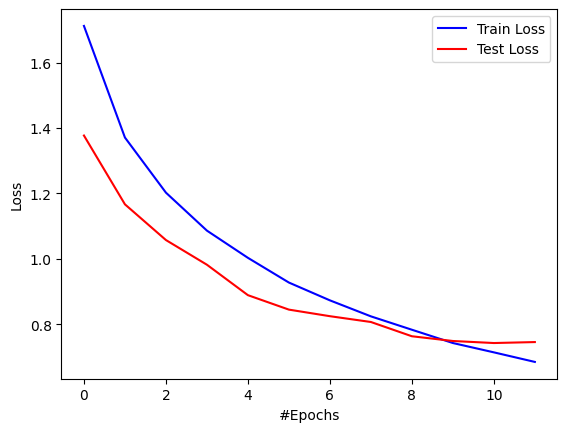

In [ ]:
#Training parameters
num_epochs = 16
print_interval = 1
learning_rate = 0.001
batch_size = 100

#Create model
network = CNN_Even_Better()

#Set optimizer and loss function
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

#Load the data, and split it into batches
training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

print("Loaded Data")

trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)

computeLabelAccuracy(network, training_generator, "Train Set")
computeLabelAccuracy(network, testing_generator, "Test Set")

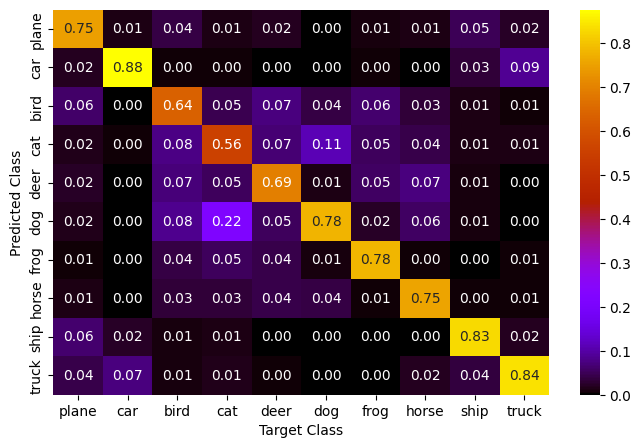

In [ ]:
graphConfusionMatrix(testing_dataset)

In [ ]:
print(network)

CNN_Even_Better(
  (conv1): Conv2d(3, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(15, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l1): Linear(in_features=960, out_features=400, bias=True)
  (l2): Linear(in_features=400, out_features=50, bias=True)
  (l3): Linear(in_features=50, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [ ]:
from torchsummary import summary
network.cuda()
summary(network, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 15, 32, 32]             420
         MaxPool2d-2           [-1, 15, 16, 16]               0
            Conv2d-3           [-1, 30, 16, 16]           4,080
         MaxPool2d-4             [-1, 30, 8, 8]               0
            Conv2d-5             [-1, 60, 8, 8]          16,260
         MaxPool2d-6             [-1, 60, 4, 4]               0
           Dropout-7                  [-1, 960]               0
            Linear-8                  [-1, 400]         384,400
           Dropout-9                  [-1, 400]               0
           Linear-10                   [-1, 50]          20,050
          Dropout-11                   [-1, 50]               0
           Linear-12                   [-1, 10]             510
Total params: 425,720
Trainable params: 425,720
Non-trainable params: 0
-------------------------------